In [2]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
home = os.path.expanduser("~")
project_path =  home+'/Dropbox/Work_main/to_be_transition_project/'
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [4]:
import analysis.mathematical_functions.funcs as funcs

In [5]:
data_folder = os.path.relpath('.')
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [6]:
data_files

['./24-08-09--26-07-2023abm_result_feather']

In [7]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [8]:
datadf['first_tb'].unique()

array([         inf,  33.98518051,  35.04977653, ..., 976.33059197,
       477.31150091, 663.36188387])

In [12]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
kappa_s = np.array(sorted(list(set(datadf['kappa']))))
N = datadf['N'].unique()[0]

In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
mu_s


array([0.0001])

In [20]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results/parameter_runs/'+ folder_name
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [21]:
parallel_subfolder

'results/parameter_runs/proper_pd_3'

In [22]:
if len(data_files)==1:
    dataname = data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]
    results_name = results_folder+'/'+dataname
else:
    raise ValueError

In [23]:
def get_p_evo_from_df(R0,mu,xi, kappa, datadf, pbar = None):
    dpdf = datadf.query(f'infection_rate =={R0} & mutation_rate=={mu} & xi=={xi} & kappa=={kappa}')
    if pbar is not None:
        pbar.update(1)
    return 1-len(dpdf[datadf.isin([np.inf, -np.inf]).any(axis=1)])/len(dpdf)

In [24]:
prog_bar = tqdm(total= len(list(funcs.product(mu_s,xi_s,R0s, kappa_s))))
if not os.path.exists(results_name+'p_evo_df.feather'):
    p_evo_df = pd.DataFrame.from_dict({i:(mu,xi,r, kappa ,get_p_evo_from_df(r,mu,xi, kappa ,datadf,prog_bar)) for i,(mu,xi,r,kappa) in tqdm(enumerate(funcs.product(mu_s,xi_s,R0s, kappa_s)))},orient='index', columns=['mu','xi','R0', 'kappa','p_evo'])
    p_evo_df.to_feather(results_name+'p_evo_df.feather')
else:
    p_evo_df = pd.read_feather(results_name+'p_evo_df.feather')

  0%|          | 0/1320 [00:00<?, ?it/s]

In [25]:
p_evo_df['p_alpha'] = datadf['p_alpha'].unique()[0]
p_evo_df['N'] = datadf['N'].unique()[0]
p_evo_df['mu'] = datadf['mutation_rate'].unique()[0]

p_evo_df['xi_d']=  -1/np.log(1-p_evo_df['p_alpha'])


In [26]:
p_evo_df

,mu,xi,R0,kappa,p_evo,p_alpha,N,xi_d
0,0.0001,23.025851,1.023293,0.000000,0.019,0.1,1000000,9.491222
1,0.0001,23.025851,1.023293,0.995262,0.014,0.1,1000000,9.491222
2,0.0001,23.025851,1.023293,2.981072,0.021,0.1,1000000,9.491222
3,0.0001,23.025851,1.023293,6.943282,0.027,0.1,1000000,9.491222
4,0.0001,23.025851,1.023293,14.848932,0.015,0.1,1000000,9.491222
...,...,...,...,...,...,...,...,...
1315,0.0001,4605.170186,5.000000,62.095734,0.022,0.1,1000000,9.491222
1316,0.0001,4605.170186,5.000000,124.892541,0.028,0.1,1000000,9.491222
1317,0.0001,4605.170186,5.000000,250.188643,0.033,0.1,1000000,9.491222
1318,0.0001,4605.170186,5.000000,500.187234,0.045,0.1,1000000,9.491222


In [27]:
p_evo_df['mut_strength'] = p_evo_df['xi_d']/p_evo_df['xi'] * np.log(p_evo_df['mu']*p_evo_df['N'])

In [28]:
# fig,ax= plt.subplots(1,1,figsize=(10,10))
# sns.lineplot(p_evo_df, x='mut_strength', y='p_evo', hue= 'kappa_plot', style= 'R0' ,legend='False', hue_norm=mpl.colors.LogNorm(), ax=ax)
# ax.set_xscale('log')

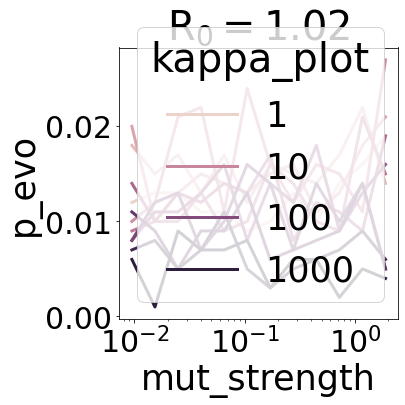

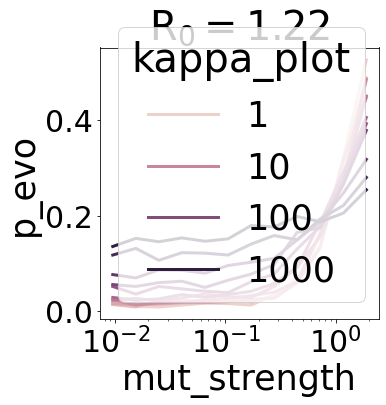

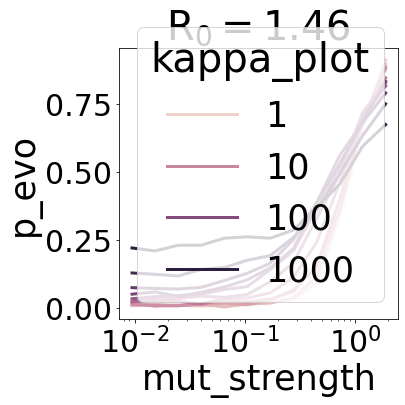

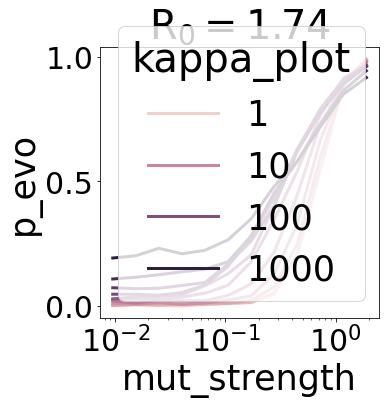

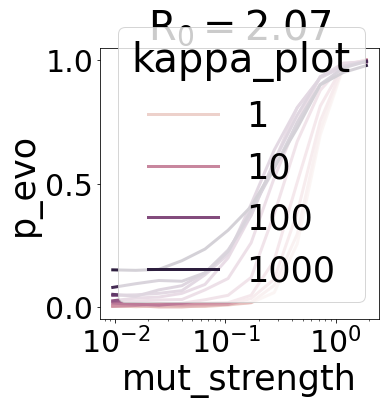

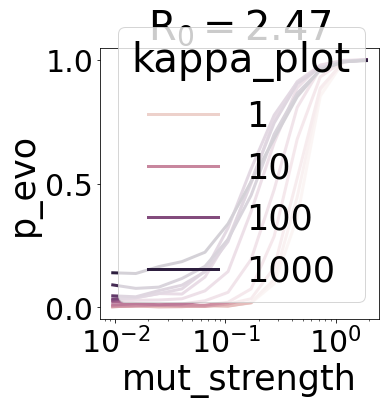

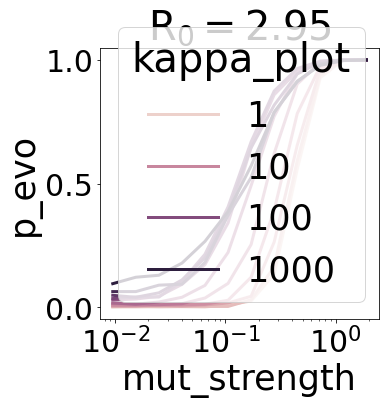

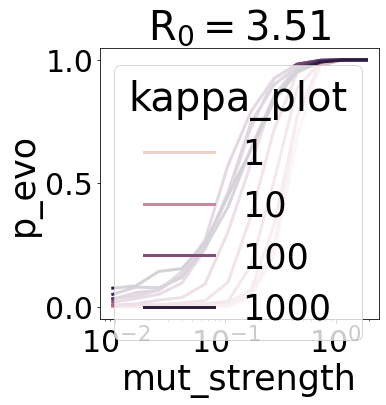

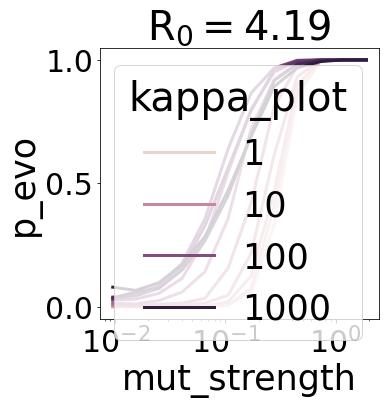

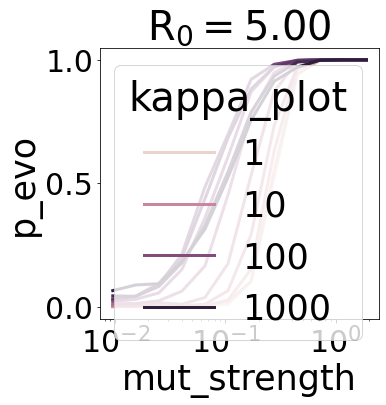

In [42]:
p_evo_df['kappa_plot'] = 1 + np.round(p_evo_df['kappa'],2)
for R0 in R0s:
    fig,ax= plt.subplots(1,1,figsize=(5,5))
    sns.lineplot(p_evo_df.query(f'R0=={R0}'), x='mut_strength', y='p_evo', hue= 'kappa_plot' ,legend='brief', hue_norm=mpl.colors.LogNorm(), ax=ax)
    ax.set_xscale('log')
    ax.set_title(fr'$R_0={R0:.2f}$')


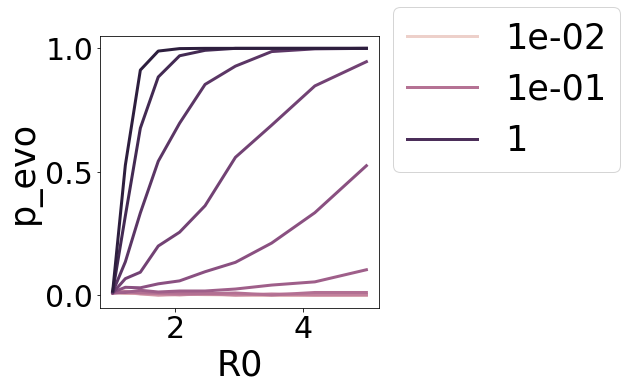

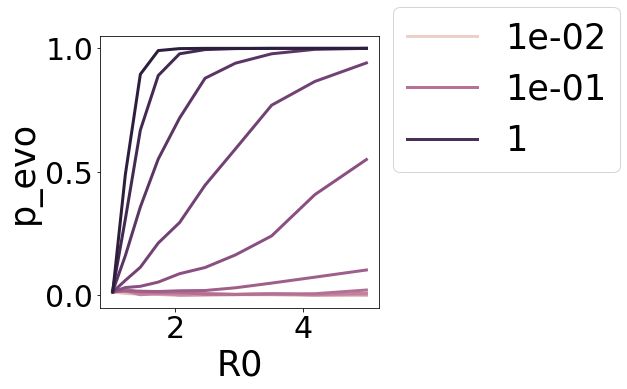

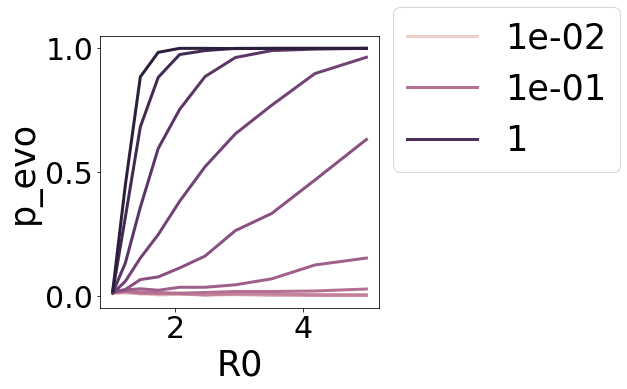

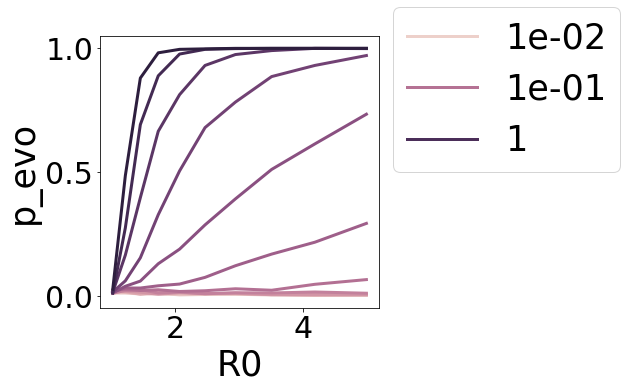

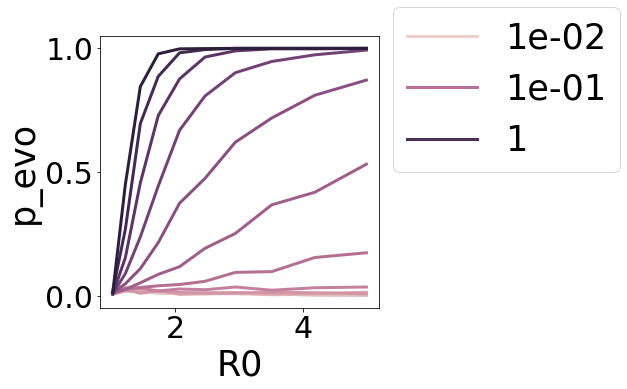

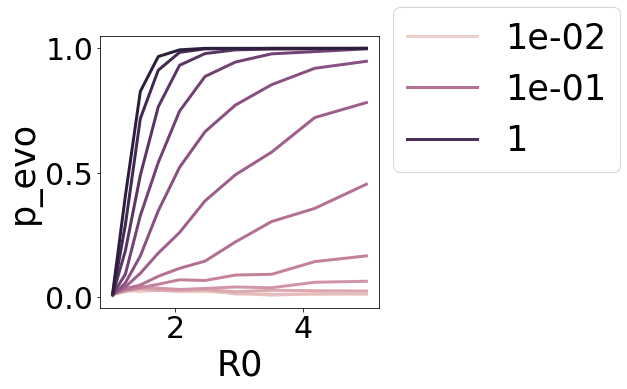

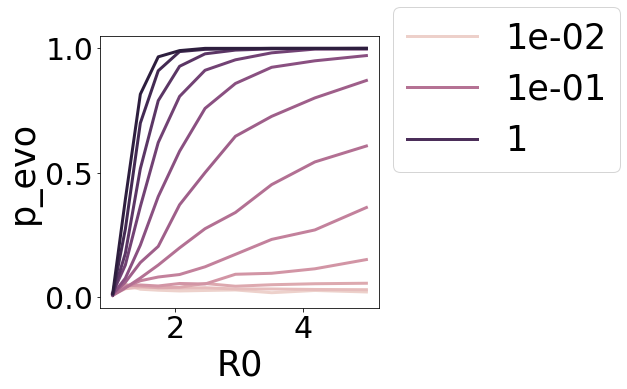

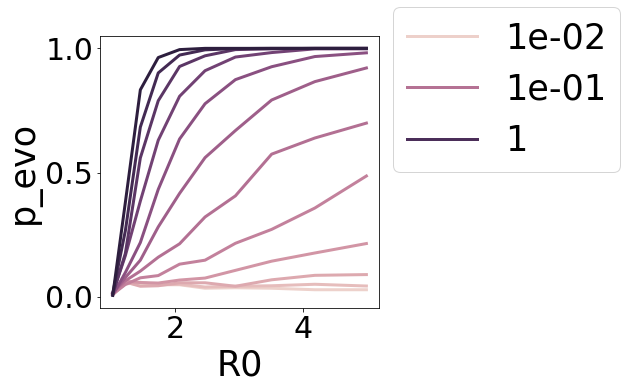

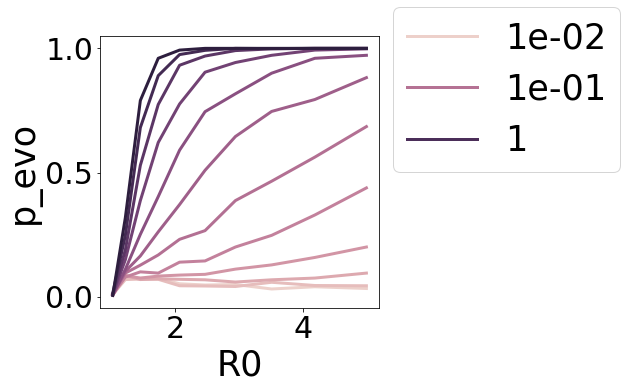

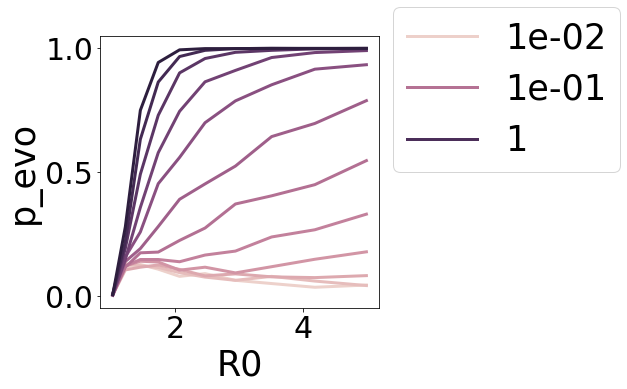

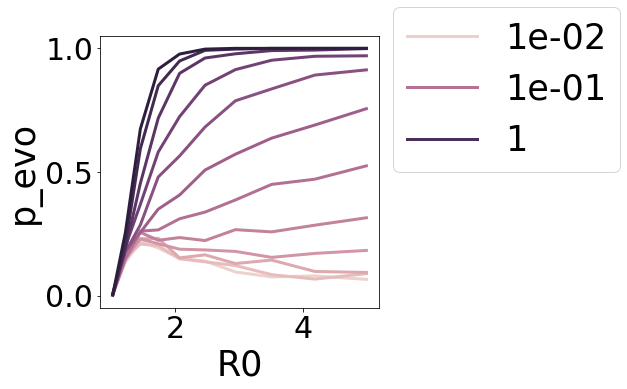

In [46]:
for kappa in kappa_s:
    fig,ax= plt.subplots(1,1,figsize=(5,5))
    sns.lineplot(p_evo_df.query(f'kappa=={kappa}'), x='R0', y='p_evo', hue= 'mut_strength' ,legend='brief', hue_norm=mpl.colors.LogNorm(), ax=ax)
    # ax.set_xscale('log')
    # ax.set_title(fr'$\kappa={kappa:.2f}$')
    ax.legend(loc= (1.05,0.5))

In [30]:

# fig, ax= plt.subplots(1,1,figsize=(10,10))

# sns.scatterplot(p_evo_df.query(f'kappa == {kappa}'), x='mut_strength', y='R0', hue='p_evo', ax=ax, s=100, legend=False, palette='coolwarm', vmin = 0, vmax = 1)
# #create colorbar of p_evo

# fig.colorbar(ax.collections[0], ax=ax, label=r'$p_\mathrm{evo}$')



# ax.set_xscale('log')

In [35]:
x_mu_strengths = p_evo_df['mut_strength'].unique()
x_mu_strengths = np.sort(x_mu_strengths)

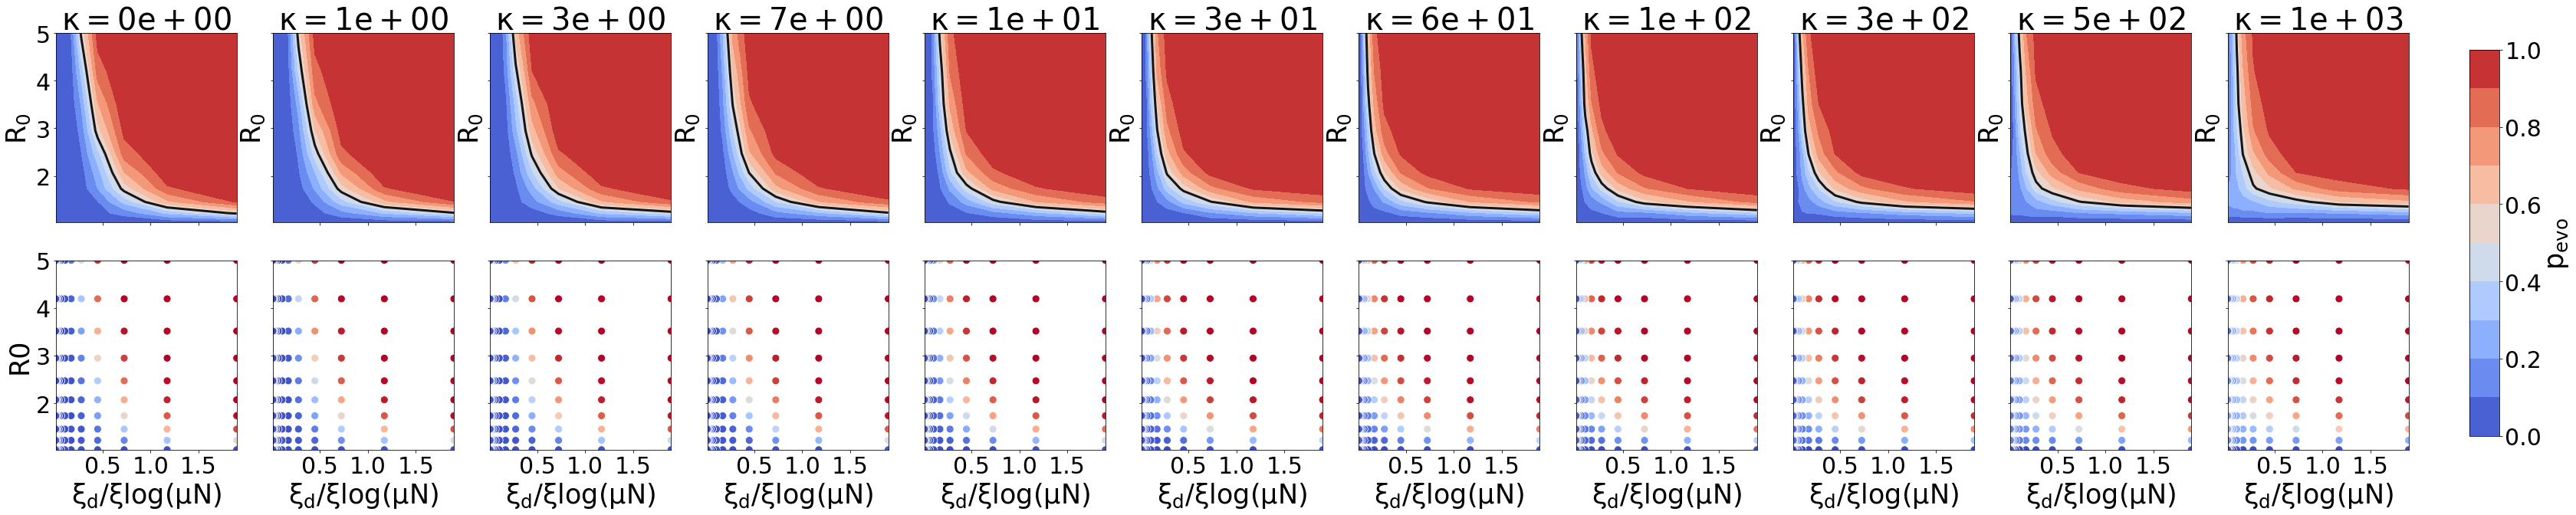

In [94]:
fig, ax= plt.subplots(2,len(kappa_s),figsize=(len(kappa_s)*5,10),sharey=True,sharex=True)
for ik,kappa in enumerate(kappa_s):    
   
    p_evo_arr = np.zeros((len(R0s),len(x_mu_strengths)))
    for iR0,R0 in enumerate(R0s):
        for i,x_mu in enumerate(x_mu_strengths):
            p_evo_arr[iR0,i] = p_evo_df.query(f'kappa == {kappa} & R0 == {R0} & mut_strength == {x_mu}')['p_evo'].values


    im = ax[0,ik].contourf( x_mu_strengths[np.argsort(x_mu_strengths)] ,R0s, p_evo_arr[:,:] ,levels=10, vmax= 1, vmin = 0)
    l  = ax[0,ik].contour(x_mu_strengths[np.argsort(x_mu_strengths)] ,R0s, p_evo_arr, levels = [0.5], alpha = 0.9, colors = 'k', linewidths = 3)


    ax[0,ik].set_title(fr'$\kappa={kappa:.0e}$')
    ax[1,ik].set_xlabel(r'$\xi_d/\xi \log(\mu N)$')
    ax[0,ik].set_ylabel(r'$R_0$')

    # ax[0,ik].set_xscale('log')
    # ax[0,ik].set_yscale('log')

    sns.scatterplot(p_evo_df.query(f'kappa == {kappa}'), x='mut_strength', y='R0', hue='p_evo', ax=ax[1,ik], s=100, legend=False, palette='coolwarm', vmin = 0, vmax = 1)
#add a colorbar 
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cax, label=r'$p_\mathrm{evo}$')
# fig.tight_layout()


plt.savefig(results_folder+'/p_evo_vs_R0_empirical_lin_lin.pdf', bbox_inches='tight')

In [86]:
results_folder

'../../../../../Work_main/to_be_transition_project/results/parameter_runs/proper_pd_3'

<AxesSubplot:xlabel='mut_strength', ylabel='R0'>

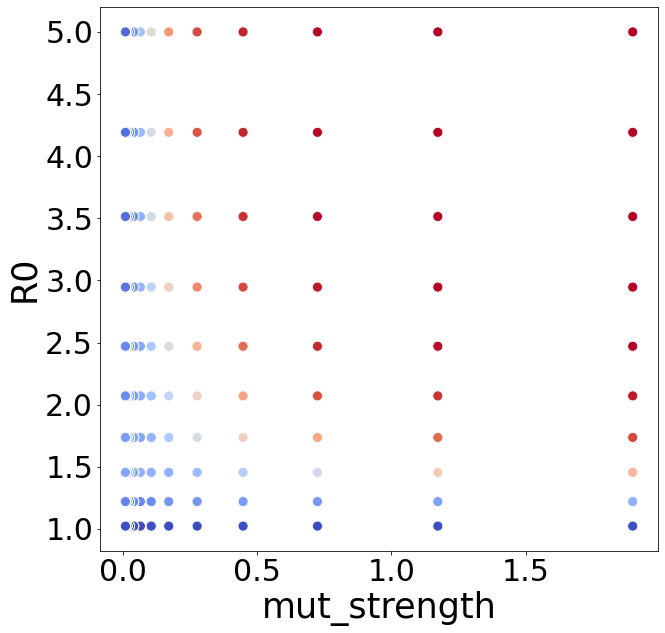

In [80]:
xx, rr = np.meshgrid(x_mu_strengths, R0s)

fig, ax= plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(p_evo_df, x='mut_strength', y='R0', hue='p_evo', ax=ax, s=100, legend=False, palette='coolwarm', vmin = 0, vmax = 1)

